In [1]:
import math
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import tifffile
from skimage import data
from skimage import io
from skimage import measure, segmentation, morphology
from skimage.filters import gaussian
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
from skimage.measure import label, regionprops, regionprops_table
from scipy.stats import pearsonr

In [2]:
def extract_pixel(image, coords):
    '''
    Extracts pixel values from original image

    Parameters
    image: Original images of tumor, macro and vessel channels
    coords: coordinates of interested ROIs (whose area is 20<area<10000)

    Returns
    Pixel values from the original images depending on interested ROIs
    '''
    pixels = np.zeros(len(coords))
    for idx, c in enumerate(coords):
        pixels[idx] = image[c[0], c[1]]
    return pixels

In [3]:
def remove_artifact_one_zscale(zscale, img_tumor, img_vessel, img_macro, corrval_tm, coords_ok):
    '''
    Parameters
    zscale: scale to loop over
    img_tumor: original tumor channel
    img_macro: macrophage channel from the original image
    img_vessel: vessel channel from the origibal image
    corrval_tm : correlation values of (same) pixels in both tumor and macrophage channel
    coords_ok : coordinates from interested ROIs to extract pixel values
    '''
    corrcutoff = 0.4
    corrAF = corrval_tm[zscale] > corrcutoff
    # print(corrAF)
    # print(label_ok[zscale])
    coords_af = []
    for i, c in enumerate(coords_ok[zscale]):
        if corrAF[i]:
            coords_af.append(coords_ok[zscale][i])
    # print(label_af)
    tumor_ohne_af, macro_ohne_af, vessel_ohne_af = deepcopy(img_tumor[zscale]), deepcopy(img_macro[zscale]), deepcopy(
        img_vessel[zscale])
    # print(coords_af)
    for coords in coords_af:
        for c in coords:
            tumor_ohne_af[c[0], c[1]] = 0
            vessel_ohne_af[c[0], c[1]] = 0
            macro_ohne_af[c[0], c[1]] = 0
    return tumor_ohne_af, vessel_ohne_af, macro_ohne_af

In [4]:
file_dir = '/home/mnagath/Documents/data/af1'
image_list = os.listdir(file_dir)
print(image_list)
file_name = os.path.basename(image_list[0]).split('.')[0]
print(file_name)
img_read = io.imread(os.path.join(file_dir, image_list[0]))
print(img_read.shape)
im_tumor = img_read[:, :, :, :, 0]  ###assign first channel to tumor
im_macrophages = img_read[:, :, :, :, 1]  ###assign second channel to macrophages
im_vessel = img_read[:, :, :, :, 2]  ###assign third channel to vessel
no_af_image = np.zeros((im_tumor.shape[1], im_tumor.shape[2], im_tumor.shape[3], 3))
image_final = np.zeros(img_read.shape, dtype=np.uint8)

['200804_LBT070_5dpi_Pos006.tif']
200804_LBT070_5dpi_Pos006
(10, 127, 1024, 1024, 3)


In [5]:
for tscale in range(im_tumor.shape[0]):
    img_tumor = im_tumor[tscale]  ##taking tumor image from one zscale img_tumor shape is (127, 1024,1024)
    img_macro = im_macrophages[tscale]
    img_vessel = im_vessel[tscale]

    gauss_filt1 = gaussian(img_tumor, sigma=2)  ###applying gaussian filter on tumor channel
    thresh1 = threshold_sauvola(gauss_filt1, window_size = 31, k=1.5)  ###finding an otsuthreshold
    binary1 = gauss_filt1 > thresh1  ###binarizing the image using threshold value

    gauss_filt2 = gaussian(img_macro, sigma=2)  ###applying gaussian filter on macrophage channel
    thresh2 = threshold_sauvola(gauss_filt2, window_size = 31, k=1.5)  ###finding an otsu threshold
    binary2 = gauss_filt2 > thresh2  ###binarizing the image using threshold value

    intersection_img = binary1 * binary2  ###intersection of binary images

(127, 1024, 1024)


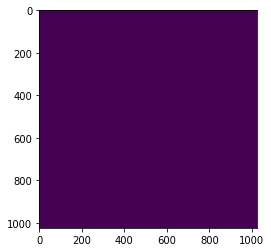

In [6]:
print(intersection_img.shape)
plt.imshow(intersection_img[0])

In [7]:
label_img_list, rp_list = [], []
for i in range(intersection_img.shape[0]):
    label_img = label(intersection_img[i]) ###labelling the ROIs in the image
    rp = regionprops_table(label_img, properties=['area', 'label', 'coords'])  ###extracting properties
    label_img_list.append(label_img)
    rp_list.append(rp)

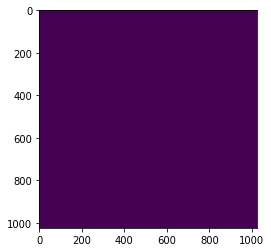

In [8]:
im1p = label(intersection_img[0])
plt.imshow(im1p)
#print(rp_list[1])

In [9]:
label_ok, coords_ok, area_ok = [], [], []
for i in range(len(label_img_list)):
    temp_label, temp_coords, temp_area = [], [], []
    for idx, area in enumerate(rp_list[i]['area']):
        if 20 < area < 10000:
            temp_label.append(
                (rp_list[i]['label'][idx]))  ###if area is less than 10000, then keep it as interested ROI
            temp_coords.append(rp_list[i]['coords'][idx])
            temp_area.append(rp_list[i]['area'][idx])
    label_ok.append(temp_label)
    coords_ok.append(temp_coords)
    area_ok.append(temp_area)
print('labels',len(label_ok))

labels 127


In [10]:
print(area_ok[0])

[]


In [11]:
tumor_mask_pix, macro_mask_pix, vessel_mask_pix = [], [], []
for i in range(len(coords_ok)):
    temp_tumor_pix, temp_macro_pix, temp_vessel_pix = [], [], []
    for coords in coords_ok[i]:
        temp_tumor_pix.append(extract_pixel(img_tumor[i],
                                            coords))  ###extract pixel values from the original image using interested ROIs
        temp_macro_pix.append(extract_pixel(img_macro[i], coords))
        temp_vessel_pix.append(extract_pixel(img_vessel[i], coords))
    tumor_mask_pix.append(temp_tumor_pix)
    macro_mask_pix.append(temp_macro_pix)
    vessel_mask_pix.append(temp_vessel_pix)

In [12]:
print(np.array(coords_ok[0]).shape)
print(macro_mask_pix[0])

(0,)
[]


In [13]:
corrval_tm, corr_trans, std_tum, std_mac, kur_tum, kur_mac = [], [], [], [], [], []
for zscale in range(len(label_img_list)):
    temp_corr = np.zeros(len(coords_ok[zscale]))
    for j in range(len(coords_ok[zscale])):  ####calculate inter-channel correlation values
        _, temp_corr[j] = np.cov(tumor_mask_pix[zscale][j], macro_mask_pix[zscale][j], bias=True)[0]
    corrval_tm.append(temp_corr)


In [14]:
print(np.min(corrval_tm[0]))
#print(corrval_tm[1])
#print(corrval_tm[2])

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
corrcutoff = 0
for i in (range(3)):
    print(i)
    corrAF = corrval_tm[i] > corrcutoff
print(corrAF)

In [15]:
tumor_no_af, vessel_no_af, macro_no_af = np.zeros_like(img_tumor), np.zeros_like(img_vessel), np.zeros_like(
    img_macro)
for zscale in range(img_tumor.shape[0]):
    tumor_no_af[zscale], vessel_no_af[zscale], macro_no_af[zscale] = remove_artifact_one_zscale(zscale,
                                                                                                img_tumor,
                                                                                                img_vessel,
                                                                                                img_macro,
                                                                                                corrval_tm,
                                                                                                coords_ok)

    no_af_image[zscale, :, :, 0] = tumor_no_af[zscale]  ###set AF detected ROIs as 0
    no_af_image[zscale, :, :, 1] = macro_no_af[zscale]
    no_af_image[zscale, :, :, 2] = vessel_no_af[zscale]

image_final[tscale] = no_af_image
# print(image_final.shape)
tifffile.imwrite((file_name + '_thres_sau' + '_af_removed.tiff'), image_final)

In [126]:
corr_val = []
for zscale in range(len(label_img_list)):
    temp_corr = np.zeros(len(coords_ok[zscale]))
    for j in range(len(coords_ok[zscale])):
        corr_val